# SchlierenCheckerboard Demo

In [1]:
import numpy as np
from skimage.io import imread
from skimage.util import img_as_float

import sys
sys.path.insert(1, '../../')
import schlieren_checkerboard as sc

Parameters of the experiment and images (these are actually the default parameters) :

In [2]:
pixmm = 0.025
sqmm  = 0.5
h     = 10
alpha = 0.24

## Analyze a single image

First load the image and create the deformed checkerboard object

In [3]:
img_file = 'images/image18.tif'
img = img_as_float(imread(img_file, as_gray=True))
dcf = sc.DeformedCheckerboard(img)

Then detect the corners and display

detect_corners: 126 corners detected


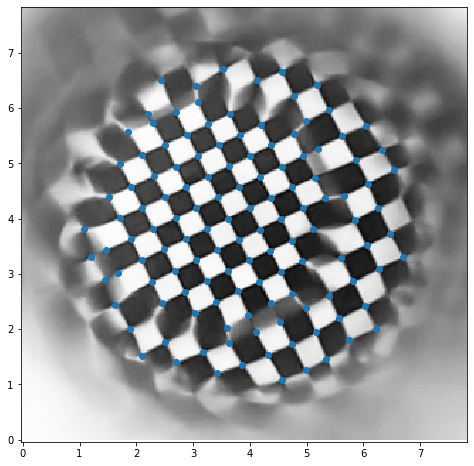

In [4]:
min_distance=8 #these are the default parameters
window_size=13
dcf.detect_corners(min_distance=min_distance, window_size=window_size)

dcf.plot_corners()

Identify the center region where the lattice is not too deformed (meaning that the curvature is roughly constant)

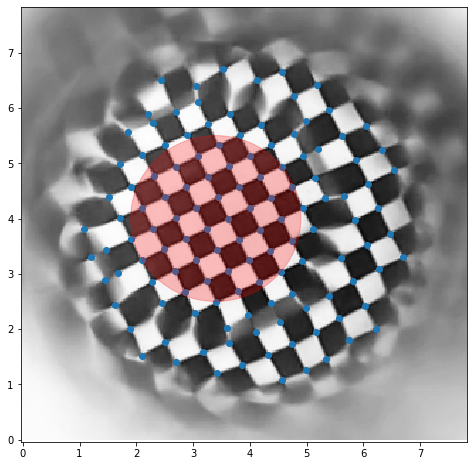

In [5]:
dcf.center = [3.4, 4., 1.5]
dcf.plot_corners()

Then match the corners to a lattice. The central point (closest to the defined center) and its nearest neighbor are used to determine the basis. Of course, the lattice matching is completely off when the deformation is large.

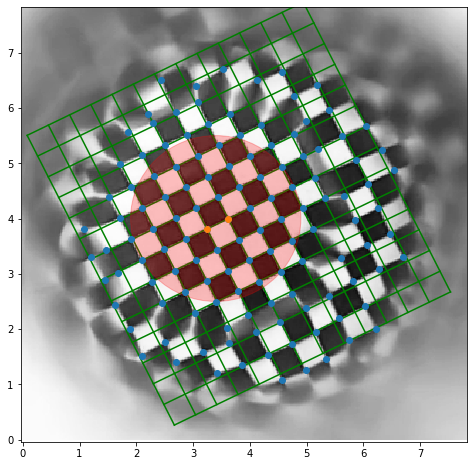

In [6]:
dcf.lattice_matching()
dcf.plot_lattice_matching()

Compute the displacement of the corners, deduce the gradient with Schlieren formula  [Moisy et al. *Exp Fluids* (2009) 46:1021–1036], and fit to a gradient of constant curvature for the center region to get the curvature.

In [7]:
dcf.disp_from_lm_corners()
dcf.grad_from_disp()
dcf.compute_center_curv()

print('Curvature in the center: ', dcf.center_curv[0], '/mm')

Curvature in the center:  0.07555093421747393 /mm


**Warning:** Since the lattice matching is completely off out of the center region, the displacement is wrong and so are all the quantities computed from it.

Below we show the full displacement field.

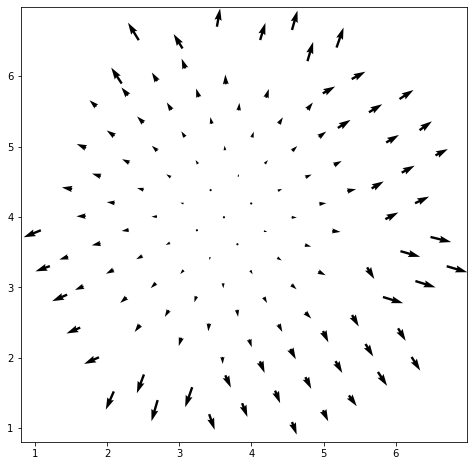

In [8]:
dcf.plot_disp()

## Analyze a sequence of images using corner tracking

First load the images

In [9]:
img_files = ['images/image{:02d}.tif'.format(i) for i in range(1, 19)]
img_list = [img_as_float(imread(img_file, as_gray=True)) for img_file in img_files]
dc_list = [sc.DeformedCheckerboard(img) for img in img_list]

Then detect the corners

In [10]:
min_distance=8 #these are the default parameters
window_size=13

for dc in dc_list :
    dc.detect_corners(min_distance=min_distance, window_size=window_size)

detect_corners: 145 corners detected
detect_corners: 143 corners detected
detect_corners: 141 corners detected
detect_corners: 140 corners detected
detect_corners: 136 corners detected
detect_corners: 133 corners detected
detect_corners: 126 corners detected
detect_corners: 126 corners detected
detect_corners: 123 corners detected
detect_corners: 120 corners detected
detect_corners: 121 corners detected
detect_corners: 120 corners detected
detect_corners: 121 corners detected
detect_corners: 124 corners detected
detect_corners: 125 corners detected
detect_corners: 127 corners detected
detect_corners: 129 corners detected
detect_corners: 126 corners detected


As can be seen, the curvature in the first image is almost constant and all the corners can be mapped on a square lattice. Here the center is not defined, so the corner closest to the center of mass of the detected corners is used.

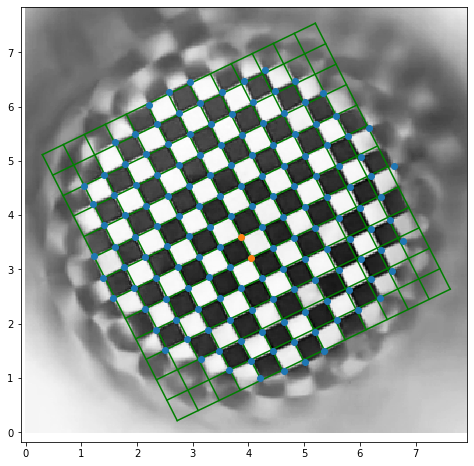

In [11]:
dc_list[0].lattice_matching()
dc_list[0].plot_lattice_matching()

Then we can track the corners between the following images in order to attribute a lattice point to every corner on all the images. This allows to get the displacement for all images.

In [12]:
for i, dc in enumerate(dc_list[1:]) :
    dc.lattice_matching_tracking(dc_list[i])

lattice_matching_tracking: 143 matches found
lattice_matching_tracking: 141 matches found
lattice_matching_tracking: 139 matches found
lattice_matching_tracking: 135 matches found
lattice_matching_tracking: 132 matches found
lattice_matching_tracking: 125 matches found
lattice_matching_tracking: 125 matches found
lattice_matching_tracking: 121 matches found
lattice_matching_tracking: 118 matches found
lattice_matching_tracking: 117 matches found
lattice_matching_tracking: 116 matches found
lattice_matching_tracking: 114 matches found
lattice_matching_tracking: 113 matches found
lattice_matching_tracking: 113 matches found
lattice_matching_tracking: 112 matches found
lattice_matching_tracking: 111 matches found
lattice_matching_tracking: 107 matches found


Now the displacement and the gradient field can be computed. Interpolating the gradient field, we have access to the curvature. Note that the curvature is by default calculated only in the convex hull of the detected corners.

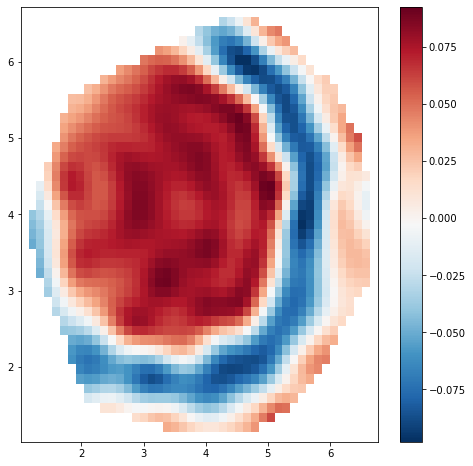

In [13]:
for dc in dc_list :
    dc.disp_from_lm_corners()
    dc.grad_from_disp()
    dc.curv_from_grad()
    
dc_list[-1].plot_curvature()

Approximating the curvature field as axisymmetric, we can get its axisymmetric approximation.

axisymmetry center: [3.3639462379028777, 4.113280015539842]


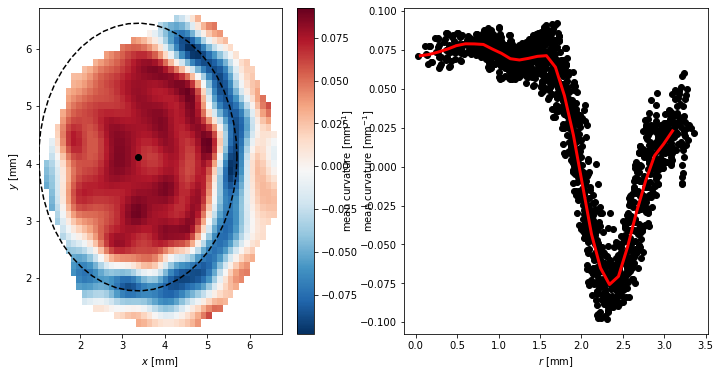

In [14]:
dc_list[-1].axisym_curv(n=30, xguess=3.5, yguess=4., optimize=True)
dc_list[-1].plot_axisym_curv()

Note the difference between the (wrong) displacement obtained before by direct lattice matching (top graph below) to the right displacement obtained with lattice tracking (bottom graph).

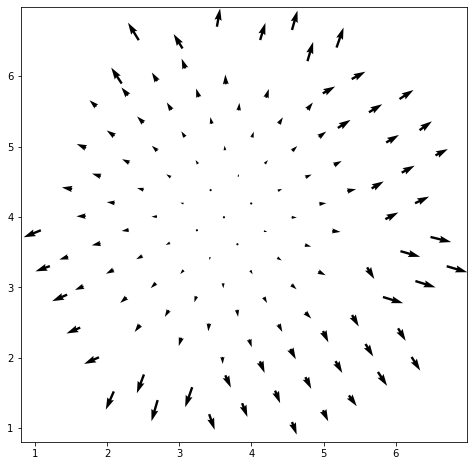

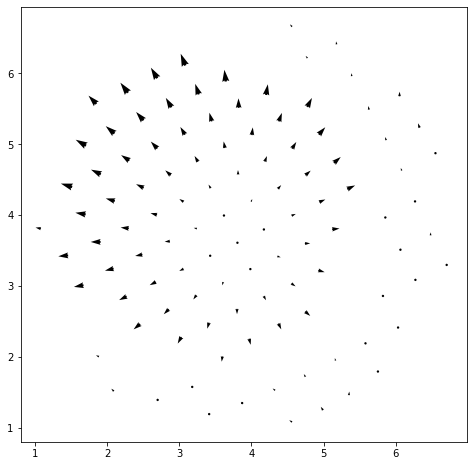

In [15]:
dcf.plot_disp()
dc_list[-1].plot_disp()

Alternatively, we can plot the gradient field in polar coordinates around the center found previously. To do that, we have to shift the gradient by a constant vector for the gradient to be zero at the center; we have this freedom since there is an arbitrary component in the gradient, which is set by the reference point that we choose.

The left panel below shows the shifted gradient field with the given center (red circle). The right panel shows the radial (filled circles) and azimuthal (open circles) components of the gradient as a function of the distance to the center.

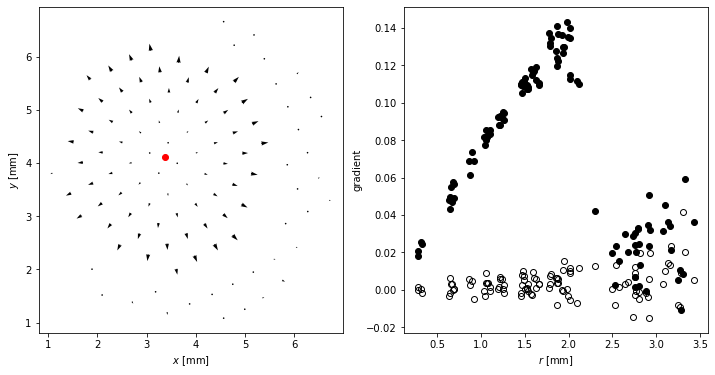

In [16]:
dc_list[-1].polar_proj_grad(*dc_list[-1].axicurv[0])
dc_list[-1].plot_polar_proj_grad()